<h1><center>Text Classification</center></h1>

In [2]:
%matplotlib inline

import time
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import random
import stanza
import re
#from preprocess import * 
#from custom_preprocessing import CustomPreProcessing
#from custom_preprocessing import PreProcessing
#from class_metric import Metrics
from googletrans import Translator
import sklearn
from sklearn.utils import class_weight
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import decomposition, ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score
from sklearn.metrics import make_scorer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence


import itertools
#from textblob import TextBlob 
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
sns.set(style="darkgrid")


import string
import fasttext
import fasttext.util
from tqdm import tqdm

# ---- Call tqdm to see progress bar with pandas
tqdm().pandas()

Using TensorFlow backend.
0it [00:00, ?it/s]
/home/chris/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
print(sklearn.__version__)
print(tf.__version__)

0.23.1
2.2.0


In [4]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

---

<h2>Content</h2>

- [Parameters](#part_1)
- [List of Models](#part_2)
- [List of Metrics for the Model Selection](#part_3)
- [Sand box to load Data](#part_4)
- [Start Pipeline](#part_5)
    - [Prepare data to ML classic](#part_5_1)
- [Machine Learning](#part_6)
    - [Class Weights](#part_6_1)
    - [Save Unique Labels](#part_6_2)
    - [DataFrame for the Results](#part_6_3)
    - [One-Hot encoding](#part_6_4)
    - [TF-IDF](#part_6_5)
    - [Load Pre-trained Model FastText](#part_6_6)
    - [Word Embeddings](#part_6_7)
    - [Multinomial Naive Bayes](#part_6_8)
    - [Logistic Regression](#part_6_9)
    - [SVM](#part_6_10)
    - [k-NN](#part_6_11)
    - [RandomForest](#part_6_12)
    - [Stochastic Gradient Descent](#part_6_13)
    - [Gradient Boosting](#part_6_14)
    - [XGBoost Classifier](#part_6_15)
- [Deep Learning](#part_7)
    - [Shallow Neural Networks](#part_7_1)
    - [Deep Neural Networks](#part_7_2)
    - [Recurrent Neural Networks (RNN)](#part_7_3)
    - [Convolutional Neural Networks (CNN)](#part_7_4)
    - [Long Short Terme Memory (LSTM)](#part_7_5)
    - [CNN-LSTM](#part_7_6)
    - [CNN-GRU](#part_7_7)
    - [Gated Recurrent Unit (GRU)](#part_7_8)
    - [Biderectional RNN](#part_7_9)
    - [Biderectional LSTM](#part_7_10)
    - [Bidirectional GRU](#part_7_11)
    - [Recurent Convulotional Neural Nerworks (RCNN)](#part_7_12)
    - [Transformers](#part_7_13)
- [Results](#part_8)
- [Visualization](#part_9)

---

<center><h2><a id="part_1">Parameters</a></h2></center>

---

This part allows you to determine the text column to classify as well as the label column.

In [5]:
TEXT = "text"
LABEL = "label"

---

<center><h2><a id="part_2">List of Models</a></h2></center>

---

In [6]:
CV_splits              = 5        # Number of splits for cross-validation and k-folds
save_results           = True
lang                   = False
sample                 = True
multinomial_naive_bayes= True
logistic_regression    = True
svm_model              = False
k_nn_model             = True
sgd                    = True
random_forest          = True
gradient_boosting      = True
xgboost_classifier     = True
shallow_network        = True
deep_nn                = True
rnn                    = True
lstm                   = True
cnn                    = True
gru                    = True
cnn_lstm               = True
cnn_gru                = True
bidirectional_rnn      = True
bidirectional_lstm     = True
bidirectional_gru      = True
rcnn                   = True
transformers           = True
pre_trained            = False

---

<center><h2><a id="part_3">List of Metrics for the Model Selection</a></h2></center>

---

In [7]:
score_metrics = {'acc': accuracy_score,
               'balanced_accuracy': balanced_accuracy_score,
               'prec': precision_score,
               'recall': recall_score,
               'f1-score': f1_score,
               'tp': tp, 'tn': tn,
               'fp': fp, 'fn': fn,
               'cohens_kappa':cohen_kappa_score,
               'matthews_corrcoef':matthews_corrcoef,
               "roc_auc":roc_auc_score}

---

<center><h2><a id="part_4">Sand Box to Load Data</a></h2></center>

---

The sandbox is the working area of your data if it has not been processed before using the pipe

In [8]:
# Functions for preprocessing
def remove_upper_case( text):
    '''
    Function to transform upper string in title words
    @param text: (str) text 
    @return: (str) text without upper words 
    '''
    sentences = text.split("\n")
    new_sentences = []
    for i in sentences:
        words = text.split()
        stripped = [w.title() if w.isupper() else w for w in words]
        new_sentences.append(" ".join(stripped))
    return "\n".join(new_sentences)
  
def remove_URL( text):
    '''
    Function to remove url from text.
    @param text: (str) sentence
    @return: (str) clean text

    '''
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
    
    
def remove_html( text):
    '''
    Function regex to clean text from html balises.
    @param text: (str) sentence 
    @return: (str) clean text 
    '''
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
    
    

def remove_emoji( text):
    '''
    Function to remove emojis, symbols and pictograms etc from text
    @param text: (str) sentences 
    @return: (str) clean text 
    '''
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [8]:
%%script false --no-raise-error
df = pd.read_csv("mails_clean_new.csv", sep=";")
df[LABEL][df[LABEL]!="annulation"] = "other"
print(df[LABEL].value_counts())
print(df[TEXT].isnull().sum())
#df[TEXT][df[TEXT].isnull()] = "empty"
df.dropna(subset=[TEXT])

In [15]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/chris/.wget-hsts'. HSTS will be disabled.
--2020-06-08 23:02:31--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  7.52MB/s    in 15s     

2020-06-08 23:02:46 (5.50 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [9]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in tqdm(sorted(os.listdir(train_path))):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)
    print("\nTrain done\n")
    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in tqdm(sorted(os.listdir(test_path))):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)
    print("\nTest done\n")
    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [10]:
%%time
#%%script false --no-raise-error
(x_train, y_train), (x_test, y_test) = load_imdb_sentiment_analysis_dataset("../Datasets/")

df = pd.DataFrame(data=[x_train, y_train], index=["text", "label"]).T
df = df.append(pd.DataFrame(data=[x_test, y_test], index=["text", "label"]).T)

df[TEXT] = df[TEXT].apply(remove_upper_case)
df[TEXT] = df[TEXT].apply(remove_URL)
df[TEXT] = df[TEXT].apply(remove_html)
df[TEXT] = df[TEXT].apply(remove_emoji)

print(df.head())

100%|██████████| 12500/12500 [03:46<00:00, 55.07it/s]



Train done



100%|██████████| 12500/12500 [03:57<00:00, 52.59it/s]



Test done

                                                text label
0  Possible SPOILERSThe Spy Who Shagged Me is a m...     0
1  The long list of "big" names in this flick (in...     0
2  Bette Midler showcases her talents and beauty ...     1
3  Great movie when I saw it. Have to say one of ...     1
4  Although it's most certainly politically incor...     1
CPU times: user 51.1 s, sys: 54.7 s, total: 1min 45s
Wall time: 16min 54s


---

<center><h2><a id="part_5">Sart Pipeline</a></h2></center>

---

In [11]:
def detect_lang_google( x):
        '''
        Function to detect the language of the string
        @param x: (str) sentences of text to detect language
        @return: (str or nan) language of the sentence
        '''
        translate = Translator()
        try:
            return translate.detect(x).lang
        except:
            return np.nan

In [12]:
if lang:
    # ---- Language detection of the text
    df.loc[:,"language"] = df[TEXT].progress_apply(detect_lang_google)
    # ---- Extract most frequent language 
    language = df.language.value_counts().index.tolist()[0]
    print(f"The language most present in the dataset is {language}")
else:
    language="en"

---

---

<center><h3><a id="part_5_1">Prepare data for ML Classic</a></h3></center>

---

In [13]:
if sample:
    df_save = df.copy()
    df = df.sample(5000, random_state=42)

In [14]:
df.shape

(5000, 2)

In [15]:
# ---- Load stopwords 
if language=="fr":
    stop_word = np.loadtxt("../stopwords/stopwords-fr.txt", dtype=str)
if language=="en":
    stop_word = np.loadtxt("../stopwords/stopwords_en.txt", dtype=str)

In [16]:
def remove_stop_words( x, stop_word):
        '''
        Function to remove a list of words
        @param x : (str) text 
        @param stop_word: (list) list of stopwords to delete 
        @return: (str) new string without stopwords 
        '''
        x_new = text_to_word_sequence(x)    # tokenize text 
        x_ = []
        for i in x_new:
            if i not in stop_word:
                x_.append(i)
        return " ".join(x_)

In [17]:
df.loc[:,TEXT+"_sw"] = df.loc[:,TEXT].progress_apply(lambda x : remove_stop_words(x, stop_word))

100%|██████████| 5000/5000 [00:31<00:00, 161.00it/s]


In [18]:
if df[TEXT+"_sw"].isnull().sum()>0:
    print("Empty text")
    df.dropna(subset=[TEXT+"_w"])
    #df[TEXT+"_sw"][df[TEXT+"_sw"].isnull()] = "empty_text"

---

---

<center><a id="part_6"><h1>Machine Learning</h1></a></center>

---

---

In [19]:
# split the dataset into training and validation datasets 
# ML classic 
train_x_sw, valid_x_sw, y_train_sw, y_valid_sw = model_selection.train_test_split(df[TEXT+"_sw"], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# For Embeddings
train_x, valid_x, y_train, y_valid = model_selection.train_test_split(df[TEXT], df[LABEL], random_state=42, stratify=df[LABEL], test_size=0.2)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y_sw = encoder.fit_transform(y_train_sw)
valid_y_sw = encoder.fit_transform(y_valid_sw)
train_y = encoder.fit_transform(y_train)
valid_y = encoder.fit_transform(y_valid)

---

<center><a id="part_6_1"><h3>Class Weights</h3></a></center>

---

In [48]:
# Compute the class weight with sklearn 
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

/home/chris/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass classes=[0 1], y=8784     1
18183    0
536      1
5872     1
5142     1
        ..
12214    1
11163    1
5107     1
12958    0
23463    0
Name: label, Length: 4000, dtype: object as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [49]:
print(*[f'Class weight: {round(i[0],4)}\tclass: {i[1]}' for i in zip(class_weights, np.unique(y_train))], sep='\n')

Class weight: 1.0194	class: 0
Class weight: 0.9814	class: 1


In [50]:
# Determined if the dataset is balanced or imbalanced 
ratio = np.min(df.label.value_counts()) / np.max(df.label.value_counts())
if ratio > 0.1:      # Ratio 1:10 -> limite blanced / imbalanced 
    balanced = True
    print(f"\nThe dataset is balanced (ratio={round(ratio, 3)})")
else:
    balanced = False
    print(f"\nThe dataset is imbalanced (ratio={round(ratio, 3)})")
    #from imblearn.over_sampling import ADASYN
    # put class for debalanced data 
    # in progress


The dataset is balanced (ratio=0.962)


---

<center><a id="part_6_2"><h3>Save Unique Labels</h3></a></center>

---

In [37]:
# Keep the unique label corresponding to their encoding correspondance
labels = df[LABEL].unique()
test=pd.DataFrame(data=np.transpose([labels,encoder.fit_transform(labels)]), columns=["labels", "encoding"]).sort_values(by=["encoding"])
labels=test.labels.tolist()
if any([0,1]) in labels and len(labels)==2:
    labels[labels.index(0)] = "negative"
    labels[labels.index(1)] = "positive"

---

<center><a id="part_6_3"><h3>DataFrame for the results</h3></a></center>

---

In [39]:
df_results = pd.DataFrame()

---

<center><a id="part_6_4"><h3>One-Hot encoding (CountVectorizing)</h3></a></center>

---

In [53]:
%%time
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df[TEXT]+"_sw")

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x_sw)
xvalid_count =  count_vect.transform(valid_x_sw)

CPU times: user 1.61 s, sys: 0 ns, total: 1.61 s
Wall time: 1.62 s


In [54]:
#xtrain_tfidf.toarray()[0][xtrain_tfidf.toarray()[0]  >0]

---

<center><a id="part_6_5"><h3>TF-IDF</h3></a></center>

---

In [55]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vect.fit(df[TEXT])
xtrain_tfidf =  tfidf_vect.transform(train_x_sw)
xvalid_tfidf =  tfidf_vect.transform(valid_x_sw)
print("word level tf-idf done")
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=10000)
tfidf_vect_ngram.fit(df[TEXT])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x_sw)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(valid_x_sw)
print("ngram level tf-idf done")
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char',  ngram_range=(2,3), max_features=10000) #token_pattern=r'\w{1,}',
tfidf_vect_ngram_chars.fit(df[TEXT])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(train_x_sw) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(valid_x_sw) 
print("characters level tf-idf done")

word level tf-idf done
ngram level tf-idf done
characters level tf-idf done
CPU times: user 18.3 s, sys: 1.27 s, total: 19.6 s
Wall time: 19.8 s


---

<center><a id="part_6_6"><h3>Load Pre-Trained model fastText</h3></a></center>

---

In [40]:
%%time
if language=="fr":
    #!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.bin.gz
    #!gunzip cc.fr.300.bin.gz
    pretrained = fasttext.FastText.load_model('../Pretrained-models/cc.fr.300.bin')
if language=="en":
    #!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
    #!unzip crawl-300d-2M-subword.zip
    pretrained = fasttext.FastText.load_model('../Pretrained-models/crawl-300d-2M-subword.bin')

CPU times: user 11.1 s, sys: 29.2 s, total: 40.3 s
Wall time: 1min


---

<center><a id="part_6_7"><h3>Word Embeddings</h3></a></center>

---

In [41]:
%%time 
# create a tokenizer 
token = Tokenizer()
token.fit_on_texts(df[TEXT])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=300)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=300)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
words = []
for word, i in tqdm(word_index.items()):
    embedding_vector = pretrained.get_word_vector(word) #embeddings_index.get(word)
    words.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

100%|██████████| 43321/43321 [00:02<00:00, 16293.77it/s]

CPU times: user 7.19 s, sys: 594 ms, total: 7.78 s
Wall time: 9.79 s


In [29]:
#words[1], embedding_matrix[1]

In [58]:
def report(clf, x, y, name='classifier', cv=5, dict_scoring=None, fit_params=None):
    '''
    Function create a metric report automatically with cross_validate function.
    @param clf: (model) classifier
    @param x: (list or matrix or tensor) training x data
    @param y: (list) label data 
    @param name: (string) name of the model (default classifier)
    @param cv: (int) number of fold for cross-validation (default 5)
    @param dict_scoring: (dict) dictionary of metrics and names
    @param fit_aparams: (dict) add parameters for model fitting 
    @return: (pandas.dataframe) dataframe containing all the results of the metrics 
    for each fold and the mean and std for each of them
    '''
    if dict_scoring!=None:
        score = dict_scoring.copy() # save the original dictionary
        for i in score.keys():
            score[i] = make_scorer(score[i]) # make each function scorer
    
    scores = cross_validate(clf, x, y, scoring=score,
                         cv=cv, return_train_score=False, n_jobs=-1,  fit_params=fit_params)
    # initialisation 
    index = []
    value = []
    index.append("Model")
    value.append(name)
    for i in scores:  # loop on each metric generate text and values
        if i == "estimator":
            continue
        for j in enumerate(scores[i]):
            index.append(i+"_cv"+str(j[0]+1))
            value.append(j[1])
        
        
        index.append(i+"_mean")
        value.append(np.mean(scores[i]))
        index.append(i+"_std")
        value.append(np.std(scores[i]))
        
    return pd.DataFrame(data=value, index=index).T

---

<center><a id="part_6_8"><h3>Multinomial Naive Bayes</h3></a></center>

---

In [ ]:
%%time
if multinomial_naive_bayes:
    df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_count,train_y_sw, name='NB_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf,train_y, name='NB_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram,train_y, name='NB_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(naive_bayes.MultinomialNB(), xtrain_tfidf_ngram_chars,train_y, name='NB_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(naive_bayes.MultinomialNB(), train_seq_x,train_y, name='NB_Words', cv=CV_splits, dict_scoring=score_metrics))

---

<center><a id="part_6_9"><h3>Logistic Regression</h3></a></center>

---

In [ ]:
%%time
if logistic_regression:
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_count,train_y_sw, name='LR_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf,train_y, name='LR_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram,train_y, name='LR_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), xtrain_tfidf_ngram_chars,train_y, name='LR_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(linear_model.LogisticRegression(max_iter=1000), train_seq_x,train_y, name='LR_Words', cv=CV_splits, dict_scoring=score_metrics))

---

<center><a id="part_6_10"><h3>SVM</h3></a></center>

---

In [ ]:
%%time
if svm_model:
    df_results = df_results.append(report(svm.SVC(), xtrain_count,train_y_sw, name='SVM_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(svm.SVC(), xtrain_tfidf,train_y, name='SVM_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(svm.SVC(), xtrain_tfidf_ngram,train_y, name='SVM_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(svm.SVC(), xtrain_tfidf_ngram_chars,train_y, name='SVM_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(svm.SVC(), train_seq_x,train_y, name='SVM_Words', cv=CV_splits, dict_scoring=score_metrics))

---

<center><a id="part_6_11"><h3>k-NN</h3></a></center>

---

In [ ]:
%%time
if k_nn_model:
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), xtrain_count,train_y_sw, name='kNN_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), xtrain_tfidf,train_y, name='kNN_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), xtrain_tfidf_ngram,train_y, name='kNN_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), xtrain_tfidf_ngram_chars,train_y, name='kNN_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=-1), train_seq_x,train_y, name='kNN_Words', cv=CV_splits, dict_scoring=score_metrics))

---

<center><a id="part_6_12"><h3>RandomForest</h3></a></center>

---

In [ ]:
%%time
if random_forest:
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_count,train_y_sw, name='RF_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_tfidf,train_y, name='RF_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_tfidf_ngram,train_y, name='RF_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), xtrain_tfidf_ngram_chars,train_y, name='RF_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(ensemble.RandomForestClassifier(bootstrap=True,min_impurity_decrease=1e-7,n_jobs=-1, random_state=42), train_seq_x,train_y, name='RF_Words', cv=CV_splits, dict_scoring=score_metrics))

---

<center><a id="part_6_13"><h3>Stochastic Gradient Descent</h3></a></center>

---

In [ ]:
%%time
if sgd:
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_count,train_y_sw, name='SGD_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf,train_y, name='SGD_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf_ngram,train_y, name='SGD_N-Gram_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), xtrain_tfidf_ngram_chars,train_y, name='SGD_CharLevel_Vectors', cv=CV_splits, dict_scoring=score_metrics))
    df_results = df_results.append(report(SGDClassifier(loss='modified_huber', max_iter=1000, tol=1e-3,   n_iter_no_change=10, early_stopping=True, n_jobs=-1 ), train_seq_x,train_y, name='SGD_Words', cv=CV_splits, dict_scoring=score_metrics))

---

<center><a id="part_6_14"><h3>Gradient Boosting</h3></a></center>

---

In [ ]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_count,train_y_sw, name='GB_Count_Vectors', cv=CV_splits, dict_scoring=score_metrics))

In [ ]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_tfidf,train_y, name='GB_WordLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))

In [ ]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_tfidf_ngram,train_y, name='GB_N-Gram_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))

In [ ]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), xtrain_tfidf_ngram_chars,train_y, name='GB_CharLevel_TF-IDF', cv=CV_splits, dict_scoring=score_metrics))

In [ ]:
%%time
if gradient_boosting:
    df_results = df_results.append(report(ensemble.GradientBoostingClassifier(n_estimators=1000,
                                               validation_fraction=0.2,
                                               n_iter_no_change=10, tol=0.01,
                                               random_state=0, verbose=0 ), train_seq_x,train_y, name='GB_Words', cv=CV_splits, dict_scoring=score_metrics))

---

<center><a id="part_6_15"><h3>XGBoost Classifier</h3></a></center>

---

All the XGBoost have early stopping implemented with 10 rounds

In [ ]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_count, valid_y_sw)]}
    df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_count,train_y_sw, name='XGB_Count_Vectors', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))


In [ ]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_tfidf, valid_y_sw)]}
    df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf,train_y, name='XGB_WordLevel_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))

In [ ]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_tfidf_ngram, valid_y_sw)]}
    df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf_ngram,train_y, name='XGB_N-Gram_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))

In [ ]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(xvalid_tfidf_ngram_chars, valid_y_sw)]}
    df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf_ngram_chars,train_y, name='XGB_CharLevel_TF-IDF', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))

In [ ]:
%%time
if xgboost_classifier:
    fit_params={'early_stopping_rounds':10,\
                         'eval_set':[(valid_seq_x,valid_y)]}
    df_results = df_results.append(report(XGBClassifier(n_estimators=1000, subsample=0.8), train_seq_x,train_y, name='XGB_Words', cv=CV_splits, fit_params=fit_params, dict_scoring=score_metrics))

---

<center><a id="part_7"><h2>Deep Learning</h2></a></center>

---

<h3>Cohen’s kappa</h3>

The function [cohen_kappa_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html#sklearn.metrics.cohen_kappa_score) computes [Cohen’s kappa](https://en.wikipedia.org/wiki/Cohen%27s_kappa) statistic. This measure is intended to compare labelings by different human annotators, not a classifier versus a ground truth.

The kappa score (see docstring) is a number between -1 and 1. Scores above .8 are generally considered good agreement; zero or lower means no agreement (practically random labels).

Kappa scores can be computed for binary or multiclass problems, but not for multilabel problems (except by manually computing a per-label score) and not for more than two annotators.

<h3>Balanced Accuracy</h3>

Compute the balanced accuracy

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. It is defined as the average of recall obtained on each class.

The best value is 1 and the worst value is 0 when adjusted=False

---

<h3>Early Stopping, Model saving, Class weight configuration</h3>

In [42]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', patience=3)
check_p = tf.keras.callbacks.ModelCheckpoint("save_models/model.h5", save_best_only=True)

In [ ]:
class_w = {}
for i in zip(range(len(class_weights)), class_weights):
    class_w[i[0]] = i[1]

---

In [55]:
def cross_validate_NN(model, X, y, X_test, y_test, callbacks,name="NN", fit_params=None, scoring=None, n_splits=5):
    '''
    Function create a metric report automatically with cross_validate function.
    @param model: (model) neural network model
    @param X: (list or matrix or tensor) training X data
    @param y: (list) label data 
    @param X_test: (list or matrix or tensor) testing X data
    @param y_test: (list) label test data 
    @param callbacks: (function) callback function
    @param name: (string) name of the model (default classifier)
    @param fit_aparams: (dict) add parameters for model fitting 
    @param scoring: (dict) dictionary of metrics and names
    @param n_splits: (int) number of fold for cross-validation (default 5)
    @return: (pandas.dataframe) dataframe containing all the results of the metrics 
    for each fold and the mean and std for each of them
    '''
    # ---- Parameters initialisation
    seed = 42
    k = 1
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Creation of list for each metric
    if scoring==None:        # create a dictionary if none is passed
        dic_scoring = {}
    if scoring!=None:        # save the dict 
        dic_score = scoring.copy()
        
    dic_score["fit_time"] = None   # initialisation for time fitting and scoring
    dic_score["score_time"] = None
    scorer = {}
    for i in dic_score.keys(): 
        scorer[i] = []
        
    
    index = ["Model"]
    results = [name]
    # ---- Loop on k-fold for cross-valisation
    for train, test in kfold.split(X, y):   # training NN on each fold 
        # create model
        print(f"k-fold : {k}")
        fit_start = time.time()
        _model = model
        _model.fit(X[train], y[train],
                        epochs=1000, callbacks=[callbacks],
                        validation_split=0.2, verbose=False)
        
        fit_end = time.time() - fit_start

        _acc = _model.evaluate(X[test], y[test], verbose=0)

        score_start = time.time()
        y_pred = (model.predict(X_test)>0.5).astype(int)
        score_end = time.time() - score_start

        # ---- save each metric
        for i in dic_score.keys():    # compute metrics 
            if i == "fit_time":
                scorer[i].append(fit_end)
                index.append(i+'_cv'+str(k))
                results.append(fit_end)
                continue
            if i == "score_time":
                scorer[i].append(score_end)
                index.append(i+'_cv'+str(k))
                results.append(score_end)
                continue
                
            scorer[i].append(dic_score[i](y_test, y_pred))
            index.append("test_"+i+'_cv'+str(k))
            results.append(scorer[i][-1])
        
        k+=1
    
    # Train test on the overall data
    fit_start = time.time()
    _model = model
    _model.fit(X, y,epochs=1000, callbacks=[callbacks],
                        validation_split=0.2, verbose=False)
        
    fit_end = time.time() - fit_start

    _acc = _model.evaluate(X_test, y_test, verbose=0)

    score_start = time.time()
    y_pred = (model.predict(X_test)>0.5).astype(int)
    score_end = time.time() - score_start
    
    # Compute mean and std for each metric
    for i in scorer: 
        
        results.append(np.mean(scorer[i]))
        results.append(np.std(scorer[i]))
        if i == "fit_time":
            index.append(i+"_mean")
            index.append(i+"_std")
            continue
        if i == "score_time":
            index.append(i+"_mean")
            index.append(i+"_std")
            continue
        
        index.append("test_"+i+"_mean")
        index.append("test_"+i+"_std")
    # add metrics averall dataset on the dictionary 
    for i in dic_score.keys():    # compute metrics 
        if i == "fit_time":
            scorer[i].append(fit_end)
            index.append(i+'_overall')
            results.append(fit_end)
            continue
        if i == "score_time":
            scorer[i].append(score_end)
            index.append(i+'_overall')
            results.append(score_end)
            continue
                
        scorer[i].append(dic_score[i](y_test, y_pred))
        index.append("test_"+i+'_overall')
        results.append(scorer[i][-1])
            
            
            
    return pd.DataFrame(results, index=index).T

---

<center><a id="part_7_1"><h3>Shallow Neural Networks</h3></a></center>

---

In [44]:
def shallow_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a shallow neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) shallow neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 16)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2: # binary
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else:  # multiclass 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    
    return model

In [47]:
%%time
if shallow_network:
    df_results = df_results.append(cross_validate_NN(shallow_neural_networks(word_index, pre_trained=pre_trained), train_seq_x, train_y, valid_seq_x, valid_y, es, name="Shallow_NN_WE", scoring=score_metrics, n_splits=CV_splits))

k-fold : 1
k-fold : 2
k-fold : 3
k-fold : 4
k-fold : 5
CPU times: user 14min 19s, sys: 57.7 s, total: 15min 16s
Wall time: 12min 26s


---

<center><a id="part_7_2"><h3>Deep Neural Networks</h3></a></center>

---

In [95]:
def deep_neural_networks(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 50)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation="relu"),#tf.nn.swish),
      keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [96]:
%%time
if deep_nn:
    df_results = df_results.append(cross_validate_NN(deep_neural_networks(word_index, pre_trained=pre_trained), train_seq_x, train_y, valid_seq_x, valid_y, es, name="Deep_NN_WE",scoring=score_metrics, n_splits=5))

k-fold : 1
k-fold : 2
k-fold : 3
k-fold : 4
k-fold : 5
CPU times: user 18min 27s, sys: 1min 28s, total: 19min 55s
Wall time: 6min 10s


<h4>Deep Neural Networks variation 1</h4>

In [93]:
def deep_neural_networks_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(16, activation="relu"),#tf.nn.swish),
      keras.layers.Dense(16, activation="relu"),#tf.nn.swish),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [94]:
%%time
if deep_nn:
    df_results = df_results.append(cross_validate_NN(deep_neural_networks_var1(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="Deep_NN_var1_WE",scoring=score_metrics, n_splits=CV_splits))

k-fold : 1
k-fold : 2
k-fold : 3
k-fold : 4
k-fold : 5
CPU times: user 18min 21s, sys: 8min 50s, total: 27min 12s
Wall time: 8min 47s


<h4>Deep Neural Networks variation 2</h4>

In [ ]:
def deep_neural_networks_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a deep neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) deep neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
      embedded,
      keras.layers.GlobalAveragePooling1D(),
      keras.layers.Dense(32, activation='relu'),
      keras.layers.Dense(16, activation='relu'),
      keras.layers.Dense(1  if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model


In [ ]:
%%time
if deep_nn:
    df_results = df_results.append(cross_validate_NN(deep_neural_networks_var2(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="Deep_NN_var2_WE",scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_3"><h3>Recurent Neural Network (RNN)</h3></a></center>

---

In [ ]:
def create_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a recurrent neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) recurrent neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SimpleRNN(40, return_sequences=True, activation='tanh'),
    keras.layers.SimpleRNN(40, return_sequences=True, activation='tanh'),
    keras.layers.SimpleRNN(40, return_sequences=True, activation='tanh'),
    keras.layers.SimpleRNN(40, activation="tanh"),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if rnn:
    df_results = df_results.append(cross_validate_NN(create_rnn_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="RNN_WE",scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_4"><h3>Convolutional Neural Network (CNN)</h3></a></center>

---

In [89]:
def create_conv_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(100, 5, activation="relu"),#tf.nn.swish), # padding='same'
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(64, 5, activation="relu"),#tf.nn.swish),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.Conv1D(32, 5, activation="relu"),#tf.nn.swish),
    keras.layers.Dropout(0.2),
    keras.layers.GlobalMaxPooling1D(),

    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [90]:
%%time
if cnn:
    df_results = df_results.append(cross_validate_NN(create_conv_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="CNN_WE",scoring=score_metrics, n_splits=CV_splits))

k-fold : 1
k-fold : 2
k-fold : 3
k-fold : 4
k-fold : 5
CPU times: user 52min 38s, sys: 7min 48s, total: 1h 26s
Wall time: 17min 6s


---

<center><a id="part_7_4"><h3>Long Short Term Memory (LSTM)</h3></a></center>

---

In [ ]:
def create_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)lstm 
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) +1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.LSTM(32, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if lstm:
    df_results = df_results.append(cross_validate_NN(create_lstm_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="LSTM_WE",scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_6"><h3>CNN – LSTM</h3></a></center>

---

In [ ]:
def create_cnn_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network lstm
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.LSTM(32, activation='tanh'),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if cnn_lstm:
    df_results = df_results.append(cross_validate_NN(create_cnn_lstm_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es,name="CNN_LSTM_WE", scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_7"><h3>CNN – GRU</h3></a></center>

---

In [ ]:
def create_cnn_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a convulational neural network GRU for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) convulational neural network GRU
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.MaxPooling1D(pool_size=4),
    keras.layers.GRU(32, activation='tanh'),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if cnn_gru:
    df_results = df_results.append(cross_validate_NN(create_cnn_gru_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="CNN_GRU_WE", scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_8"><h3>Gated Recurrent Units – GRU</h3></a></center>

---

tf.keras.layers.GRU(
    units, activation='tanh', recurrent_activation='sigmoid', use_bias=True,
    kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
    bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None,
    bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
    recurrent_constraint=None, bias_constraint=None, dropout=0.0,
    recurrent_dropout=0.0, implementation=2, return_sequences=False,
    return_state=False, go_backwards=False, stateful=False, unroll=False,
    time_major=False, reset_after=True, **kwargs
)

In [ ]:
def create_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a GRU for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) GRU
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.GRU(32, activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if gru:
    df_results = df_results.append(cross_validate_NN(create_gru_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="GRU_WE", scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_9"><h3>Bidirectional RNN</h3></a></center>

---

In [ ]:
def create_bidirec_rnn_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a bidirectionnal rnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectionnal rnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True, activation="tanh")),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True, activation="tanh")),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True, activation="tanh")),
    keras.layers.Bidirectional(keras.layers.SimpleRNN(32, activation="tanh")),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if bidirectional_rnn:
    df_results = df_results.append(cross_validate_NN(create_bidirec_rnn_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="BiRNN_WE",scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_10"><h3>Bidirectional LSTM</h3></a></center>

---

In [ ]:
def create_bidirec_lstm_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a bidirectionnal lstm for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectionnal lstm
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.LSTM(32, activation="tanh")),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if bidirectional_lstm:
    df_results = df_results.append(cross_validate_NN(create_bidirec_lstm_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="BiLSTM_WE",scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_11"><h3>Bidirectional GRU</h3></a></center>

---

In [ ]:
def create_bidirec_gru_model(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a bidirectionnal gru for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model) bidirectionnal gru
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.Bidirectional(keras.layers.GRU(32, activation="tanh")),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if bidirectional_gru:
    df_results = df_results.append(cross_validate_NN(create_bidirec_gru_model(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="BiGRU_WE",scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_12"><h3>Recurrent Convolutional Neural Network (RCNN)</h3></a></center>

---

In [ ]:
def create_rcnn(X, word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300,input_length=X.shape[1], weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True, activation="tanh")),
    keras.layers.Convolution1D(32, 3, activation="tanh"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if rcnn:
    df_results = df_results.append(cross_validate_NN(create_rcnn(train_seq_x, word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="RCNN_WE",scoring=score_metrics, n_splits=CV_splits))

---

<h3>Recurrent Convolutional Neural Network variation 1</h3>

---

In [ ]:
def create_rcnn_var1(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True, activation="tanh")),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if rcnn:
    df_results = df_results.append(cross_validate_NN(create_rcnn_var1(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="RCNN_var1_WE",scoring=score_metrics, n_splits=CV_splits))

---

<h3>Recurrent Convulational Neural Network variation 2</h3>

---

In [ ]:
def create_rcnn_var2(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True, activation="tanh")),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True, activation="tanh")),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if rcnn:
    df_results = df_results.append(cross_validate_NN(create_rcnn_var2(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="RCNN_var2_WE",scoring=score_metrics, n_splits=CV_splits))

---

<h3>Recurrent Convulational Neural Network variation 3</h3>

---

In [ ]:
def create_rcnn_var3(word_index, label=labels, embedding_matrix=embedding_matrix, pre_trained=False):
    if pre_trained==False:
        embedded = keras.layers.Embedding(len(word_index) + 1, 100)
    else:
        embedded = keras.layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)
    
    model = keras.Sequential([
    embedded,
    keras.layers.SpatialDropout1D(0.3),
    keras.layers.Bidirectional(keras.layers.GRU(32,return_sequences=True, activation="tanh")),
    keras.layers.Bidirectional(keras.layers.LSTM(32,return_sequences=True, activation="tanh")),
    keras.layers.Convolution1D(32, 3, activation="relu"),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dense(25, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")])

    if len(label)==2:
        model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #print(model.summary())
    
    return model

In [ ]:
%%time
if rcnn:
    df_results = df_results.append(cross_validate_NN(create_rcnn_var3(word_index, pre_trained=pre_trained), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="RCNN_var3_WE",scoring=score_metrics, n_splits=CV_splits))

---

<center><a id="part_7_13"><h3>Transformers</h3></a></center>

Tutorial available on Keras documentation, code example written by Apoorv Nandan (<a href="https://keras.io/examples/nlp/text_classification_with_transformer/">source: kears.io</a>)

---

In [68]:
from tensorflow.keras import layers

In [69]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [70]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation=tf.nn.swish), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [71]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [85]:
def transformers_classifier(word_index, label=labels):
    '''
    Function to generate a rcnn for binary or multiclass classification.
    @param word_index: (matrix) unique token in corpus
    @param label: (list) list of labels to determine if it,s a binary or multiclass
    @param embedding_matrix: (matrix) matrix of integer for each word in the 
    @param pre_trained: (bool) determine if the model will use pretrained model
    @return: (model)  rcnn
    '''
    embed_dim = 32  # Embedding size for each token
    num_heads = 2  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer
    vocab_size = len(word_index)+1
    maxlen = 300
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x) #tf.nn.swish
    x = layers.Dropout(0.1)(x)
    #outputs = layers.Dense(1, activation="sigmoid")(x)
    
    outputs = keras.layers.Dense(1 if len(label)<=2 else len(label), activation='sigmoid' if len(label)<=2 else "softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    if len(label)==2:
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    else: 
        model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    print(model.summary())
    
    return model


In [86]:
if transformers:
    
    df_results = df_results.append(cross_validate_NN(transformers_classifier(word_index, label=labels), 
                                                     train_seq_x, train_y, valid_seq_x, valid_y, es, name="transformers",scoring=score_metrics, n_splits=CV_splits))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
token_and_position_embedding (None, 300, 32)           1395904   
_________________________________________________________________
transformer_block_2 (Transfo (None, 300, 32)           6464      
_________________________________________________________________
global_average_pooling1d_6 ( (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 20)                660       
_________________________________________________________________
dropout_17 (Dropout)         (None, 20)                0   

---

<center><a id="part_8"><h2>Results</h2></a></center>

---

In [14]:
df_results[[ "Model","test_acc_mean","test_acc_std", 
                        
                       "test_prec_mean", "test_prec_std", 
                        "test_recall_mean","test_recall_std", 
                       "test_f1-score_mean", "test_f1-score_std", 
                       "test_cohens_kappa_mean", "test_cohens_kappa_std", "test_matthews_corrcoef_mean","test_matthews_corrcoef_std", 
                       "test_roc_auc_mean", "test_roc_auc_std"]][df_results["test_matthews_corrcoef_mean"]>0.5].sort_values(by=["test_matthews_corrcoef_mean", "test_recall_mean"], ascending=False)[:1]

,Model,test_acc_mean,test_acc_std,test_prec_mean,test_prec_std,test_recall_mean,test_recall_std,test_f1-score_mean,test_f1-score_std,test_cohens_kappa_mean,test_cohens_kappa_std,test_matthews_corrcoef_mean,test_matthews_corrcoef_std,test_roc_auc_mean,test_roc_auc_std
9,SGD_WordLevel_TF-IDF,0.904533,0.003558,0.903289,0.005953,0.925551,0.006072,0.914256,0.003150,0.806615,0.007254,0.806987,0.007162,0.902204,0.003758
14,LR_Count_Vectors,0.902220,0.006502,0.896764,0.008218,0.929219,0.003529,0.912692,0.005567,0.801666,0.013313,0.802346,0.013113,0.899227,0.006905
17,XGB_Count_Vectors,0.900677,0.002894,0.888951,0.006372,0.936449,0.005731,0.912047,0.002351,0.798154,0.006024,0.799669,0.005712,0.896712,0.003317
15,LR_WordLevel_TF-IDF,0.899905,0.004583,0.892538,0.005471,0.929974,0.004104,0.910863,0.003990,0.796849,0.009354,0.797744,0.009264,0.896572,0.004780
18,XGB_WordLevel_TF-IDF,0.898303,0.003968,0.888787,0.006056,0.931701,0.004254,0.909720,0.003336,0.793450,0.008166,0.794652,0.007949,0.894601,0.004291
12,SGD_CharLevel_Vectors,0.897829,0.006208,0.898523,0.007719,0.917998,0.012709,0.908076,0.005908,0.793110,0.012440,0.793533,0.012696,0.895592,0.005998
21,RF_WordLevel_TF-IDF,0.896642,0.003888,0.887120,0.006699,0.930514,0.003212,0.908278,0.003124,0.790057,0.008074,0.791291,0.007713,0.892888,0.004368
8,Deep_NN_var2_WE,0.896630,0.001046,0.904108,0.007284,0.908502,0.009483,0.906223,0.001457,0.791071,0.002027,0.791247,0.002145,0.895316,0.001221
23,RF_Count_Vectors,0.895159,0.004666,0.884417,0.005064,0.931055,0.006297,0.907120,0.004163,0.786963,0.009477,0.788375,0.009524,0.891180,0.004716
52,transformers,0.894637,0.005935,0.898383,0.023930,0.912991,0.021280,0.905071,0.003611,0.786681,0.013065,0.788096,0.011700,0.892605,0.008458


In [ ]:
if save_results:
    df_results.sort_values(by=["test_prec_mean", "test_recall_mean"], ascending=False).to_csv("model_selection_results.csv", index=False)

---

<center><a id="part_9"><h2>Visualization</h2></a></center>

---

In [10]:
df_results=df_results[df_results["test_matthews_corrcoef_mean"]>0.5]

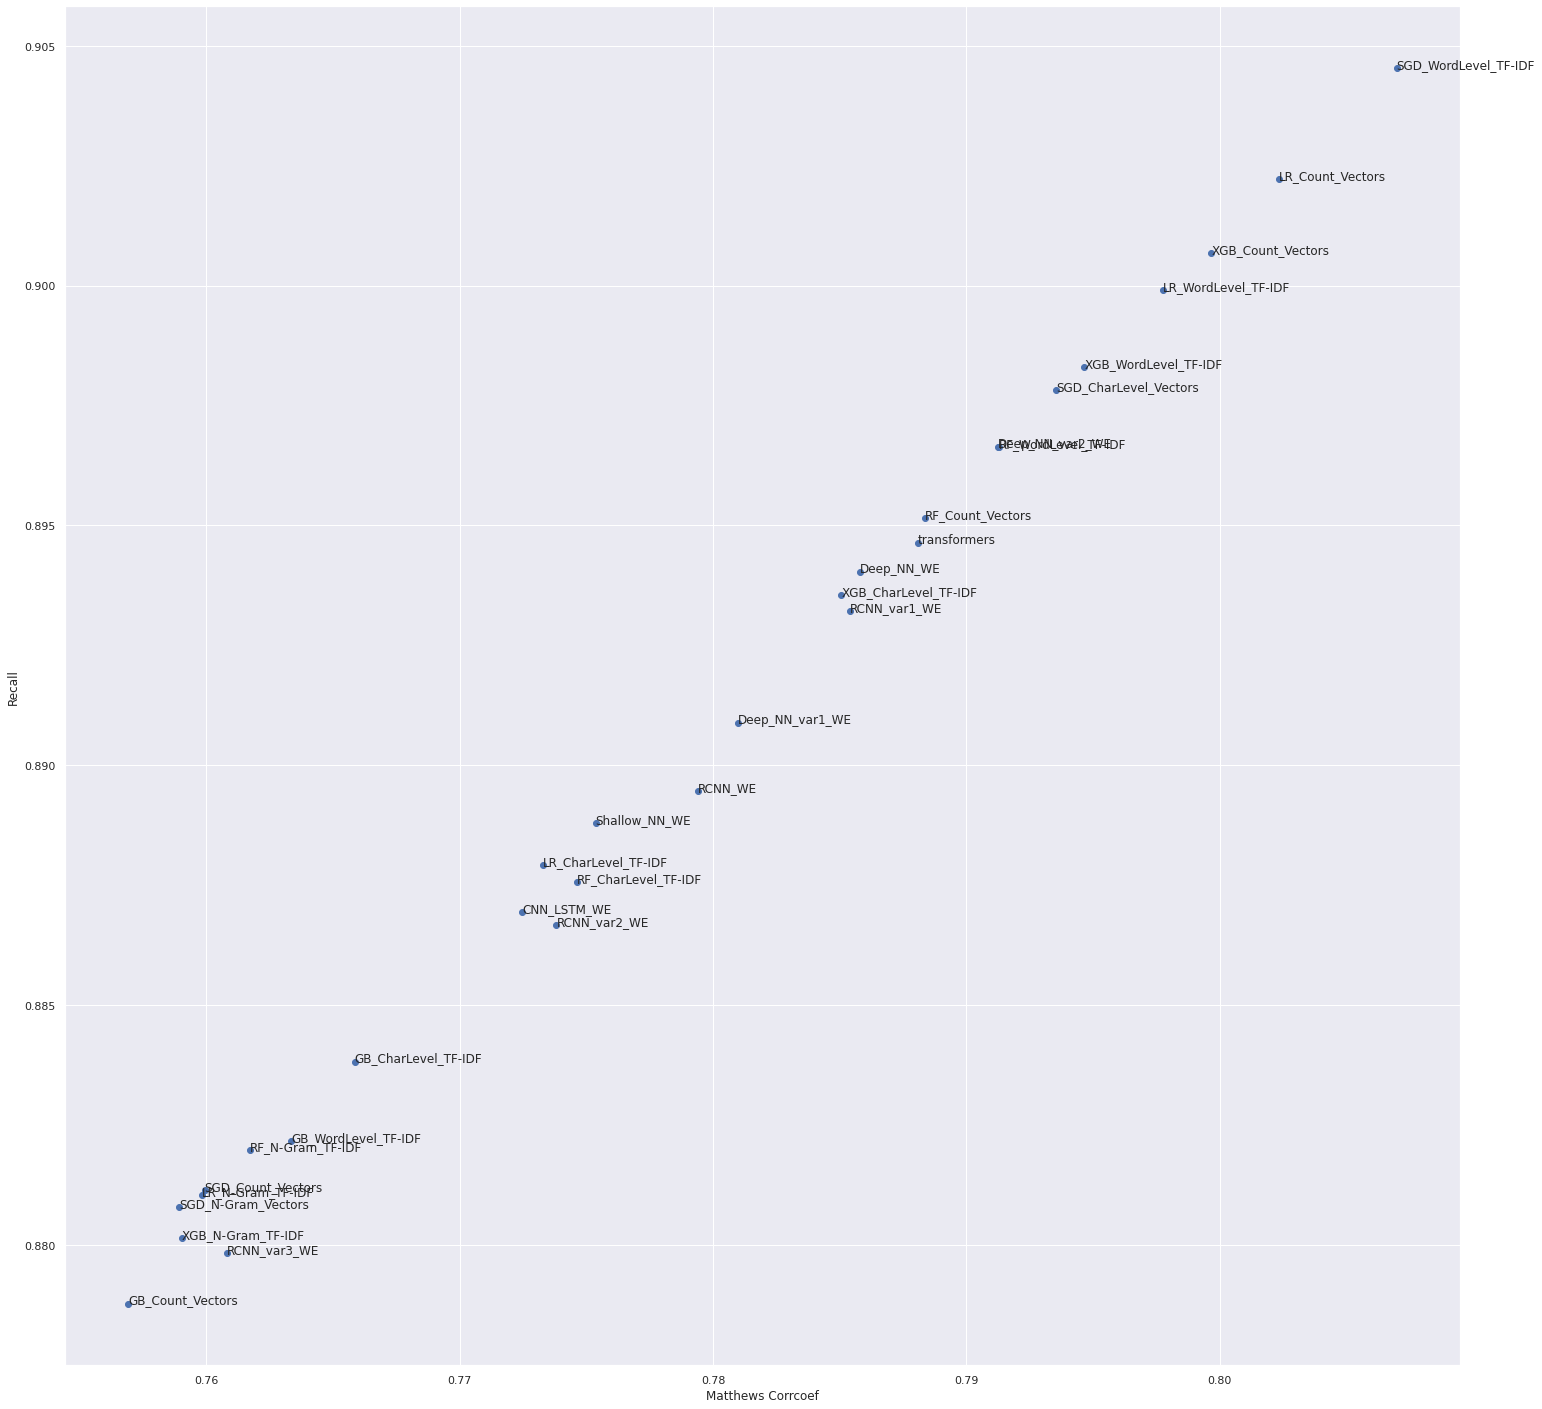

In [11]:
fig, ax = plt.subplots(figsize=(25,25))
#plt.axis([0.85,1,0.85,1])
ax.scatter(df_results["test_matthews_corrcoef_mean"], df_results["test_acc_mean"])

for i, txt in enumerate(df_results["Model"]):
    ax.annotate(txt, (df_results["test_matthews_corrcoef_mean"].iloc[i], df_results["test_acc_mean"].iloc[i]))

plt.xlabel("Matthews Corrcoef")
plt.ylabel("Recall")

plt.grid(True)
